# Aula 09 - CARS - Exercícios

In [1]:
import pandas as pd
import numpy as np
from numbers import Number

### Importar base de dados

In [2]:
! pip install uszipcode

Defaulting to user installation because normal site-packages is not writeable


In [42]:
! rm -fr ml-100k.zip
! rm -fr ./ml-100k

In [4]:
import wget
! python3 -m wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
! unzip -o ml-100k.zip

100% [......................................................] 4924029 / 4924029
Saved under ml-100k.zip
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-

In [5]:
rating = pd.read_csv('./ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
rating.drop('timestamp', axis=1, inplace=True)
rating.head()

,userId,itemId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [6]:
#Load the Movies data
item = pd.read_csv('./ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['itemId', 'title' ,'release','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

dates = item[['itemId', 'release']].sort_values(by='itemId', ascending=True)
dates['release'] = pd.to_datetime(dates['release'], errors='coerce')

item = (item
    .drop(columns=['release', 'video release date', 'IMDb URL'])
    .melt(id_vars=['itemId', 'title'], var_name='genre')
    .query('value == 1')
    .drop(columns=['value'])
).sort_values(by='itemId', ascending=True)


display(item.head())
display(dates.head())

,itemId,title,genre
8410,1,Toy Story (1995),Comedy
5046,1,Toy Story (1995),Animation
6728,1,Toy Story (1995),Children's
3365,2,GoldenEye (1995),Adventure
26913,2,GoldenEye (1995),Thriller


,itemId,release
0,1,1995-01-01
1,2,1995-01-01
2,3,1995-01-01
3,4,1995-01-01
4,5,1995-01-01


In [7]:
#Load the User data
user = pd.read_csv('./ml-100k/u.user', sep='|', encoding='latin-1', header=None)
user.columns = ['userId', 'age', 'gender', 'occupation', 'zipcode']
user.head()

,userId,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


## Questão 01

***Exercício 01:*** Na aula, vimos a implementação e a aplicação do Factorization Machines (FM) com dois tipos de contexto: gêneros dos filmes e profissão do usuário. Verifique o desempenho do RMSE quando mais informações de contexto são incorporadas:
- Década de lançamento do filme: classifique os filmes por década: 60's, 70's, 80's, 90's, etc. 
- Sexo do usuário: M ou F. 
- Faixa etária: classifique os usuários por faixa etária, por exemplo: criança (até 12 anos), adolescente (13 a 17 anos), adulto (18 a 50 anos) e idoso (acima de 51 anos). 
- CEP: utilizar a biblioteca https://www.pythonpool.com/uszipcode-python/ de acordo com o exemplo abaixo

### Obter informações do usuário a partir do CEP (https://www.pythonpool.com/uszipcode-python/)

### Consultando o estado

In [8]:
!pip install uszipcode
!pip install sqlalchemy_mate==1.4.28.4

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### Needed Modules

In [9]:
from sklearn.model_selection import train_test_split
from uszipcode import SearchEngine
from math import sqrt
import matplotlib.pyplot as plt

/home/b/.local/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Utility functions

In [10]:
def get_age_group(age : Number) -> str:
    if age < 12:
        return 'kid'
    elif age < 18:
        return 'teen'
    elif age < 51:
        return 'adult'
    else:
        return 'senior'

In [11]:
search = SearchEngine()

def get_zipcode_groups(zipcode : any) -> str:
    zipcode = search.by_zipcode(str(zipcode))
    
    return zipcode.state if zipcode else 'unknown'

In [12]:
def get_decade(date):
    if pd.isnull(date):
        return 0
    
    return date.year // 10 * 10

In [13]:
def _gen_mappings(ext, offset):
    _ext = np.sort(ext.unique())
    _mappings = {v: i + offset for i, v in enumerate(_ext)}
    new_offset = offset + len(_ext)
    
    return _mappings, new_offset

def _map_if(ext, offset : int, cur_mappings : dict, name : str, targets : list[str]):
    if name not in targets:
        return cur_mappings, offset,
    
    _mappings, offset = _gen_mappings(ext, offset)
    cur_mappings[name] = _mappings
    
    return cur_mappings, offset


valid_targets = ['decade', 'age_group', 'zipcode_group', 'genre', 'gender', 'occupation']


def gen_mappings(
    df_map : dict,
    targets : list[str] = [],
    inc_offset = True,
    start_offset = 1,
    with_coords = True
):    
    # Get Mappings
    offset = start_offset
    
    mappings = dict()
    
    if with_coords:
        user_id_mappings, new_offset = _gen_mappings(df_map['userId']['userId'], offset)
        if inc_offset:  offset = new_offset
        
        item_id_mappings, new_offset = _gen_mappings(df_map['itemId']['itemId'], offset)
        if inc_offset:  offset = new_offset
    
        mappings = {
            'userId': user_id_mappings,
            'itemId': item_id_mappings
        }
    
    # if there is a non valid target, error
    for name in targets:
        if name not in valid_targets:
            raise ValueError(f'Invalid target: {name}')
    
    for name in targets:
        mappings, new_offset = _map_if(df_map[name][name], offset, mappings, name, targets)
        if inc_offset:  offset = new_offset
    
    return mappings

In [14]:
def ext_if(df, row, id_key, name, targets, mappings, curr_row):
    if name not in targets:
        return curr_row
    
    id = row[id_key]
    _val = df.loc[df[id_key] == id, name].values[0]
    _mapped = mappings[name][_val]
    
    return curr_row + [_mapped]
    
def extract_attr(
    df,
    df_map : dict,
    id_map : dict,
    mappings : dict,
    targets : list[str] = [],
):
    _data = []
    
    do_genres = 'genre' in targets
    if do_genres: targets.remove('genre')
    
    # if there is a non valid target, error
    for name in targets:
        if name not in valid_targets:
            raise ValueError(f'Invalid target: {name}')
        
    for i, row in df.iterrows():
        _user_mapped = mappings['userId'][row['userId']]
        _item_mapped = mappings['itemId'][row['itemId']]
        
        _row = [_user_mapped, _item_mapped]
        
        for name in targets:
            _row = ext_if(df_map[name], row, id_map[name], name, targets, mappings, _row)
        
        if do_genres:
            _genres = df_map['genre'].loc[df_map['genre']['itemId'] == row['itemId'], 'genre'].values
            _genres = [mappings['genre'][_genre] for _genre in _genres]
            _row = _row + _genres
        
        _rating = row['rating'] # not mapped
        _row = _row + [_rating]
        
        _data.append(_row)
    
    return _data

In [15]:
def predict(w0, w, v, x):
    pred = w0
    for i in range(len(x)-1):
        pred += w[x[i]]
        for j in range(i+1, len(x)-1):
            pred += np.dot(v[x[i]], v[x[j]])
            
    if pred < 0:
        pred = 0.0
    if pred > 5:
        pred = 5.0
        
    return pred


def train_fm(train, n_attr, dim=5, reg=0.01, lr=0.001, decay=0.1, miter=15):
    w0 = 0
    w = np.zeros(n_attr)
    v = np.random.normal(0.0, 0.1, (n_attr, dim))
    n_samples = len(train)
    
    error = []
    for t in range(miter):
        print('Iter #', t)
        sq_error = 0
        for s in range(n_samples):
            pred = predict(w0, w, v, train[s])
            e_ui = pred - train[s][-1]
            sq_error = sq_error + e_ui**2
            
            w0 = w0 - lr*(e_ui + reg * w0)
            
            for i in range(len(train[s])-1):
                
                w[train[s][i]] = w[train[s][i]] - lr*(e_ui + reg * w[train[s][i]])
                
                for f in range(dim):
                    sum_v = 0
                    for j in range(len(train[s])-1):
                        if train[s][i] != train[s][j]:
                            sum_v += v[train[s][j]][f]
                            
                    v[train[s][i]][f] = v[train[s][i]][f] - lr*(e_ui * sum_v + reg * v[train[s][i]][f])

        error.append(sqrt(sq_error/n_samples))
        lr = lr * (1. / (1. + decay * t))

    return w0, w, v, error

In [16]:
def rmse(preds, ratings):
    if len(preds) != len(ratings):
        return -1
    sum = 0
    for i in range(len(preds)):
        sum += pow(preds[i]-ratings[i], 2)
    return sqrt(sum/len(preds))

In [17]:
def test_method(maps, train_test, targets, train_params):
    df_map, id_map, mappings = maps
    train, test = train_test
    
    data_train = extract_attr(train, df_map, id_map, mappings, targets)
    data_test = extract_attr(test, df_map, id_map, mappings, targets)
    
    n_attrib = max(max(x) for x in data_train)+1
    
    w0, w, v, error = train_fm(data_train, n_attrib, **train_params)
    
    ratings = []
    preds = []
    
    for sample in data_test:
        ratings.append(sample[-1])
        preds.append(predict(w0, w, v, sample))
        
    _rmse = rmse(preds, ratings)
    
    plt.plot(error)
    plt.show()
    
    return {
        'data_train': data_train,
        'data_test': data_test,
        'n_attrib': n_attrib,
        'w0': w0,
        'w': w,
        'v': v,
        'error': error,
        'rmse': _rmse,
        'ratings': ratings,
        'preds': preds,
    }
    

#### Pre-computando valores

In [18]:
# Train Test Split
train, test = train_test_split(rating, test_size=.2, random_state=42)
train_test = (train, test)

In [19]:
# Mining and refining the Data for easier use
user_mined = user.copy()
user_mined['age_group'] = user_mined['age'].apply(get_age_group)
user_mined['zipcode_group'] = user_mined['zipcode'].apply(get_zipcode_groups)

dates_mined = dates.copy()
dates_mined['decade'] = dates_mined['release'].apply(get_decade)

display(user_mined.head())
display(dates_mined.head())

,userId,age,gender,occupation,zipcode,age_group,zipcode_group
0,1,24,M,technician,85711,adult,AZ
1,2,53,F,other,94043,senior,CA
2,3,23,M,writer,32067,adult,FL
3,4,24,M,technician,43537,adult,OH
4,5,33,F,other,15213,adult,PA


,itemId,release,decade
0,1,1995-01-01,1990
1,2,1995-01-01,1990
2,3,1995-01-01,1990
3,4,1995-01-01,1990
4,5,1995-01-01,1990


In [20]:
df_map = {
    'occupation': user_mined,
    'decade': dates_mined,
    'age_group': user_mined,
    'zipcode_group': user_mined,
    'gender': user_mined,
    'genre': item,
    'userId': user,
    'itemId': item,
}

id_map = {
    'occupation': 'userId',
    'decade': 'itemId',
    'age_group': 'userId',
    'zipcode_group': 'userId',
    'genre': 'itemId',
    'gender': 'userId',
}

In [21]:
# generating mappings
mappings = gen_mappings(df_map, targets=['occupation', 'genre', 'gender', 'decade', 'age_group', 'zipcode_group'])
maps = (df_map, id_map, mappings)
list(mappings.keys())
# mappings

['userId',
 'itemId',
 'occupation',
 'genre',
 'gender',
 'decade',
 'age_group',
 'zipcode_group']

In [22]:
train_params = {
    'dim': 5,
    'reg': 0.01,
    'lr': 0.001,
    'decay': 0.1,
    'miter': 15,
}

#### Testando o menor contexto

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14


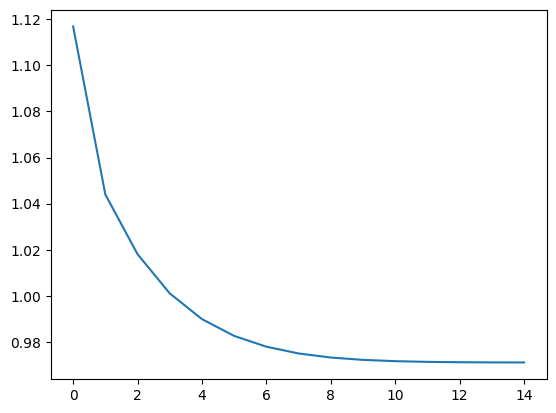

1.1415278218870757

In [23]:
targets = ['occupation', 'genre']
results_1 = test_method(maps, train_test, targets, train_params)

results_1['rmse']

#### Testando o maior contexto

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14


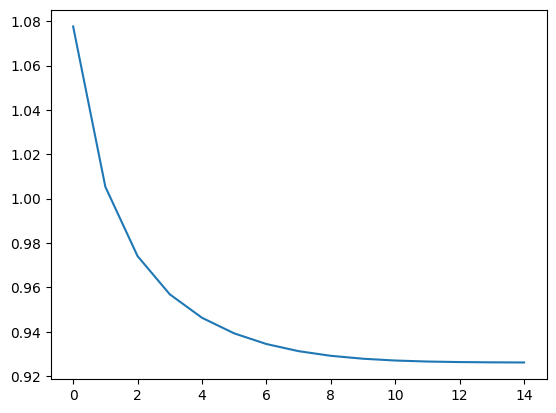

1.0211684327300852

In [24]:
targets = ['occupation', 'genre', 'gender', 'decade', 'age_group', 'zipcode_group']
results_2 = test_method(maps, train_test, targets, train_params)

results_2['rmse']

A diferença foi pequena. No entanto, o modelo com maior quantidade de contexto chegou a um erro menor em uma menor quantidade de iterações. O platô do útimo modelo também é levemente menor (ele estabilisa em um erro menor).

## Questão 02

***Exercício 02:*** Implemente a abordagem KNN do tipo *pré-filtragem*. A aplicação do contexto será feita antes de se calcular os usuários ou itens mais similares. Por exemplo, ao prever a nota de um item *i* para um usuário que é médico, selecionam-se inicialmente todos usuários com a mesma ocupação. Depois calcula-se a similaridade deles, e por fim, a predição da nota.

A escolha de contextos (relaciondos com usuários, itens ou ambos) é livre.

In [25]:
! mkdir -p ./outputs

#### Calculando similaridade por nota

In [26]:
import numpy as np
import pandas as pd

def get_user_mean(df, userId):
    '''Compute mean rating for a user'''
    return df[df['userId'] == userId]['rating'].mean()

# Pearson similarity
def comp_sim_matrix(df, sparse: bool = True):
    _df = df[['userId', 'itemId', 'rating']].copy()
    
    users = _df['userId'].unique()
    n = len(users)
    sim_matrix = np.zeros((n, n))
    
    # Precompute user means and ratings
    print('Precomputing user means and ratings...')
    user_means = {user: get_user_mean(_df, user) for user in users}
    
    user_means_df = pd.DataFrame(user_means.items(), columns=['userId', 'mean'])
    
    # Precompute the difference
    _df = pd.merge(_df, user_means_df, on='userId')
    _df['diff'] = _df['rating'] - _df['mean']
    _df.drop(columns=['mean'], inplace=True)
    
    # Precompute user ratings
    user_ratings = {user: _df[_df['userId'] == user] for user in users}

    # Compute similarity matrix
    print('Computing similarity matrix...')
    
    for i in range(n):
        u1 = users[i]
        u1_ratings = user_ratings[u1]
        
        for j in range(i):
            u2 = users[j]
            u2_ratings = user_ratings[u2]
            
            # Find common items
            both_rated = pd.merge(u1_ratings, u2_ratings, on='itemId', suffixes=('_u1', '_u2'))
            
            if both_rated.empty:
                continue

            # Dot product for the similarity
            sim = (both_rated['diff_u1'] * both_rated['diff_u2']).sum()

            # Norms for both users
            norm_u1 = np.sqrt((both_rated['diff_u1'] ** 2).sum())
            norm_u2 = np.sqrt((both_rated['diff_u2'] ** 2).sum())

            # Vectorized safe division using numpy
            denom = norm_u1 * norm_u2
            similarity = np.divide(sim, denom, where=denom != 0, out=np.zeros_like(sim))
            
            # Store the similarity in the matrix (symmetrical)
            sim_matrix[i][j] = sim_matrix[j][i] = similarity

        progress = (i + 1) / n * 100
        print(f'{progress:.2f}% done', end='\r')
    
    return np_to_pd(sim_matrix, sparse)

def np_to_pd(matrix: np.ndarray, sparse: bool = True) -> pd.DataFrame:
    rows, cols = np.nonzero(matrix) if sparse else np.indices(matrix.shape).reshape(2, -1)
    values = matrix[rows, cols]
    _df = pd.DataFrame({'i': rows, 'j': cols, 'v': values}).dropna()
    return _df


In [27]:
# Beware, this may take several minutes to compute

try:
    sim_matrix = pd.read_csv('./outputs/sim_matrix.csv', sep='\t', header=None, names=['userId-1', 'userId-2', 'similarity'])
    print('Read from disk since file exists.')
except FileNotFoundError:
    print('File not found, computing...')
    sim_matrix = comp_sim_matrix(rating).rename(columns={'i': 'userId-1', 'j': 'userId-2', 'v': 'similarity'})
    
sim_matrix.head()

File not found, computing...
Precomputing user means and ratings...
Computing similarity matrix...


,userId-1,userId-2,similarity
0,0,1,0.168740
1,0,2,0.321166
2,0,3,0.289765
3,0,4,-1.000000
4,0,5,0.023887


In [28]:
# save to file
sim_matrix.to_csv('./outputs/sim_matrix.csv', index=False, sep='\t', header=False)

#### Calculando a similaridade por contexto

In [29]:
def comp_context_sim(context):
    _sim = (
        np.dot(context, context.T) / (
            np.linalg.norm(context, axis=1)[:, None] * np.linalg.norm(context, axis=1)[None, :]
        )
    )
    
    _sim = np_to_pd(_sim)
    
    _sim.dropna(inplace=True)
    
    _sim.rename(columns={'i': 'userId-1', 'j': 'userId-2', 'v': 'similarity'}, inplace=True)
    
    _sim['userId-1'] = 1 + _sim['userId-1'].astype(int)
    _sim['userId-2'] = 1 + _sim['userId-2'].astype(int)
    
    return _sim

In [30]:
# Creatting new mappings without the accumulative offset
q2_mappings = gen_mappings(df_map, targets=['occupation', 'age_group', 'gender'], inc_offset=False)

q2_mappings

{'userId': {1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59,
  60: 60,
  61: 61,
  62: 62,
  63: 63,
  64: 64,
  65: 65,
  66: 66,
  67: 67,
  68: 68,
  69: 69,
  70: 70,
  71: 71,
  72: 72,
  73: 73,
  74: 74,
  75: 75,
  76: 76,
  77: 77,
  78: 78,
  79: 79,
  80: 80,
  81: 81,
  82: 82,
  83: 83,
  84: 84,
  85: 85,
  86: 86,
  87: 87,
  88: 88,
  89: 89,
  90: 90,
  91: 91,
  92: 92,
  93: 93,
  94: 94,
  95: 95,
  96: 96,
  97: 97,
  98: 98,
  99: 99,
  100: 100,
  101:

In [31]:
targets = ['occupation', 'age_group', 'gender']
num_users = user['userId'].max()

context_data = np.zeros((num_users, len(targets)))

for _i, row in user_mined.iterrows():
    u = row['userId']
    
    for j, target in enumerate(targets):
        context_data[u-1][j] = q2_mappings[target][row[target]]

context_data

array([[20.,  1.,  2.],
       [14.,  3.,  1.],
       [21.,  1.,  2.],
       ...,
       [19.,  1.,  2.],
       [11.,  1.,  1.],
       [19.,  1.,  2.]])

In [32]:
context_sim = comp_context_sim(context_data)

context_sim

,userId-1,userId-2,similarity
0,1,1,1.000000
1,1,2,0.986697
2,1,3,0.999986
3,1,4,1.000000
4,1,5,0.999370
...,...,...,...
889244,943,939,0.998637
889245,943,940,0.512148
889246,943,941,1.000000
889247,943,942,0.999178


In [33]:
context_sim.to_csv('./outputs/context_sim.csv', index=False, sep='\t', header=False)

#### Combinando as similaridades

In [34]:
alpha = .5

hybrid_sim = sim_matrix.merge(context_sim, on=['userId-1', 'userId-2'], suffixes=('_rating', '_context'))
hybrid_sim.fillna(0, inplace=True)

hybrid_sim['similarity_rating'] = hybrid_sim['similarity_rating'] * alpha
hybrid_sim['similarity_context'] = hybrid_sim['similarity_context'] * (1.0 - alpha)

hybrid_sim['sim'] = hybrid_sim['similarity_rating'] + hybrid_sim['similarity_context']

hybrid_sim.drop(columns=['similarity_rating', 'similarity_context'], inplace=True)
hybrid_sim.dropna(inplace=True)

# drop similarity = 0
hybrid_sim = hybrid_sim[hybrid_sim['sim'] != 0]


hybrid_sim.to_csv('./outputs/hybrid_sim.csv', index=False, sep='\t', header=False)

hybrid_sim.head()


,userId-1,userId-2,sim
0,1,2,0.528400
1,1,3,0.429357
2,1,4,0.792119
3,1,5,0.409533
4,1,6,0.400892


#### Executando o KNN

In [35]:
test.to_csv('./outputs/test.csv', index=False, sep='\t', header=False)
train.to_csv('./outputs/train.csv', index=False, sep='\t', header=False)

In [36]:
from caserec.recommenders.rating_prediction.item_attribute_knn import ItemAttributeKNN, ItemKNN

ItemAttributeKNN(
    './outputs/train.csv',
    './outputs/test.csv', 
    as_similar_first=True,
    k_neighbors=10,
    output_file='./outputs/pred-q02.csv',
    similarity_file='./outputs/hybrid_sim.csv'
).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 943 users and 1653 items (80000 interactions) | sparsity:: 94.87%
test data:: 940 users and 1411 items (20000 interactions) | sparsity:: 98.49%

training_time:: 1.290758 sec
prediction_time:: 0.227807 sec
Eval:: MAE: 0.891696 RMSE: 1.14605 


In [37]:
pred = pd.read_csv('./outputs/pred-q02.csv', sep='\t', header=None, names=['userId', 'itemId', 'rating'])
pred.head()

,userId,itemId,rating
0,1,1,5.000000
1,1,4,2.019171
2,1,6,2.820319
3,1,8,5.000000
4,1,20,3.563915


## QUestão 03

***Exercício 03:*** Implemente a abordagem KNN do tipo *pós-filtragem*. A aplicação do contexto será feita após serem calculados os usuários ou itens mais similares e a predição de notas. A pós-filtragem consiste no ajuste da predição de notas de acordo com o contexto. Pode-se usar uma estratégia do tipo nota_predita_contexto = nota_predita * fator_ajuste, em que fator_ajuste é a similaridade entre o contexto do usuário-alvo e de outros usuários que avaliaram o item.

Por exemplo, ao prever a nota de um item *i* para um usuário que é médico, calcula-se a similaridade de todos os usuários inicialmente, depois, a predição da nota. Em seguida, a predição da nota pode ser ajustada como: nota_predita_medico = nota_predita * similaridade('medico', profissoes_item), em que profissoes_item é o conjunto de todas as profissões dos usuários que avaliaram o item *i*, e similaridade pode ser Jaccard.  

A escolha de contextos (relaciondos com usuários, itens ou ambos) é livre.

In [38]:
# Running a basic KNN
ItemKNN(
    './outputs/train.csv',
    './outputs/test.csv', 
    k_neighbors=10,
    output_file='./outputs/pred-q03.csv',
).compute()

# Saving the results
q3_pred = pd.read_csv('./outputs/pred-q03.csv', sep='\t', header=None, names=['userId', 'itemId', 'rating'])

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 943 users and 1653 items (80000 interactions) | sparsity:: 94.87%
test data:: 940 users and 1411 items (20000 interactions) | sparsity:: 98.49%

training_time:: 1.428081 sec
prediction_time:: 4.025182 sec
Eval:: MAE: 0.754268 RMSE: 0.966191 


In [39]:
# Building the Context Dictionary for each Item
occup = rating.merge(user[['userId', 'occupation']], on='userId')
item_ctxt_dict = dict()

for i in item['itemId'].unique():
    item_ctxt_dict[i] = set(occup[occup['itemId'] == i]['occupation'].to_list())

item_ctxt_df = pd.DataFrame(item_ctxt_dict.items(), columns=['itemId', 'context'])


item_ctxt_df.head()

,itemId,context
0,1,"{entertainment, programmer, scientist, none, m..."
1,2,"{student, librarian, entertainment, technician..."
2,3,"{other, student, librarian, entertainment, tec..."
3,4,"{entertainment, programmer, scientist, none, m..."
4,5,"{librarian, student, entertainment, technician..."


In [40]:
# Merging the DataFrames to compute the Jaccard Similarity
q3_df = (q3_pred
    .merge(item_ctxt_df, on=['itemId'])
    .merge(user[['userId', 'occupation']], on=['userId'])
)

# Intersection and union
q3_df['intersect'] = q3_df.apply(lambda x: len(x['context'].intersection({x['occupation']})), axis=1)
q3_df['union'] = q3_df.apply(lambda x: len(x['context'].union({x['occupation']})), axis=1)

# Applying the Jaccard Similarity
q3_df['jaccard_sim'] = q3_df['intersect'] / q3_df['union']

# Scaling the rating to the Jaccard Similarity
q3_df['new_rating'] = q3_df['rating'] * q3_df['jaccard_sim']

q3_df.head()

,userId,itemId,rating,context,occupation,intersect,union,jaccard_sim,new_rating
0,1,1,3.990318,"{entertainment, programmer, scientist, none, m...",technician,1,21,0.047619,0.190015
1,1,4,3.810372,"{entertainment, programmer, scientist, none, m...",technician,1,20,0.050000,0.190519
2,1,6,3.448781,"{student, librarian, technician, executive, he...",technician,1,11,0.090909,0.313526
3,1,8,3.882497,"{entertainment, programmer, scientist, none, m...",technician,1,19,0.052632,0.204342
4,1,20,3.797183,"{entertainment, programmer, scientist, marketi...",technician,1,19,0.052632,0.199852


In [41]:
# Organizing the DataFrame
jaccard_df = q3_df[['userId', 'itemId', 'new_rating']].copy().rename(columns={'new_rating': 'pred'})

jaccard_df.head()

,userId,itemId,pred
0,1,1,0.190015
1,1,4,0.190519
2,1,6,0.313526
3,1,8,0.204342
4,1,20,0.199852
